## Bilby

In [1]:
import bilby

# Set the duration and sampling frequency of the data segment that we're
# going to inject the signal into
duration = 4.0
sampling_frequency = 1024.0
minimum_frequency = 20

# Specify the output directory and the name of the simulation.
outdir = "outdir"
label = "para_2"
bilby.core.utils.setup_logger(outdir=outdir, label=label)


# We are going to inject a binary black hole waveform.  We first establish a
# dictionary of parameters that includes all of the different waveform
# parameters, including masses of the two black holes (mass_1, mass_2),
# spins of both black holes (a, tilt, phi), etc.
injection_parameters = dict(
    mass_1=36.0,
    mass_2=29.0,
    a_1=0.4,
    a_2=0.3,
    tilt_1=0.5,
    tilt_2=1.0,
    phi_12=1.7,
    phi_jl=0.3,
    luminosity_distance=2000.0,
    theta_jn=0.4,
    psi=2.659,
    phase=1.3,
    geocent_time=1126259642.413,
    ra=1.375,
    dec=-1.2108,
)

inj_m1, inj_m2 = injection_parameters['mass_1'], injection_parameters['mass_2']
inj_chirp_mass = bilby.gw.conversion.component_masses_to_chirp_mass(inj_m1, inj_m2)
inj_q = bilby.gw.conversion.component_masses_to_mass_ratio(inj_m1, inj_m2)

# Fixed arguments passed into the source model
waveform_arguments = dict(
    waveform_approximant="IMRPhenomPv2",
    reference_frequency=20.0,
    minimum_frequency=minimum_frequency,
)

# Create the waveform_generator using a LAL BinaryBlackHole source function
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments,
)




23:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [2]:
# Set up interferometers.  In this case we'll use two interferometers
# (LIGO-Hanford (H1), LIGO-Livingston (L1). These default to their design
# sensitivity
ifos = bilby.gw.detector.InterferometerList(["H1"])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency,
    duration=duration,
    start_time=injection_parameters["geocent_time"] - 2,
)
ifos.inject_signal(
    waveform_generator=waveform_generator, parameters=injection_parameters
)



23:44 bilby INFO    : Injected signal in H1:
23:44 bilby INFO    :   optimal SNR = 11.76
23:44 bilby INFO    :   matched filter SNR = 11.14+2.31j
23:44 bilby INFO    :   mass_1 = 36.0
23:44 bilby INFO    :   mass_2 = 29.0
23:44 bilby INFO    :   a_1 = 0.4
23:44 bilby INFO    :   a_2 = 0.3
23:44 bilby INFO    :   tilt_1 = 0.5
23:44 bilby INFO    :   tilt_2 = 1.0
23:44 bilby INFO    :   phi_12 = 1.7
23:44 bilby INFO    :   phi_jl = 0.3
23:44 bilby INFO    :   luminosity_distance = 2000.0
23:44 bilby INFO    :   theta_jn = 0.4
23:44 bilby INFO    :   psi = 2.659
23:44 bilby INFO    :   phase = 1.3
23:44 bilby INFO    :   geocent_time = 1126259642.413
23:44 bilby INFO    :   ra = 1.375
23:44 bilby INFO    :   dec = -1.2108


[{'plus': array([0.00000000e+00-0.00000000e+00j, 0.00000000e+00-0.00000000e+00j,
         0.00000000e+00-0.00000000e+00j, ...,
         2.53649530e-28+6.42490693e-28j, 2.49752906e-28+6.38923495e-28j,
         0.00000000e+00-0.00000000e+00j]),
  'cross': array([0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
         6.39695530e-28-2.55646065e-28j, 6.36154321e-28-2.51744821e-28j,
         0.00000000e+00+0.00000000e+00j])}]

In [3]:

# Set up a PriorDict, which inherits from dict.
# By default we will sample all terms in the signal models.  However, this will
# take a long time for the calculation, so for this example we will set almost
# all of the priors to be equall to their injected values.  This implies the
# prior is a delta function at the true, injected value.  In reality, the
# sampler implementation is smart enough to not sample any parameter that has
# a delta-function prior.
# The above list does *not* include mass_1 and mass_2,which means those are the parameters that will be included in the
# sampler.  If we do nothing, then the default priors get used.
priors = bilby.gw.prior.BBHPriorDict()
for key in [
    "a_1",
    "a_2",
    "tilt_1",
    "tilt_2",
    "phi_12",
    "phi_jl",
    "psi",
    "ra",
    "dec",
    "geocent_time",
    "phase",
    "theta_jn",
    "luminosity_distance",
]:
    priors[key] = injection_parameters[key]
#     priors["mass_ratio"] = inj_q
    priors["chirp_mass"] = bilby.gw.prior.UniformInComponentsChirpMass(
    minimum=inj_chirp_mass - 5,
    maximum=inj_chirp_mass + 5
)

# Perform a check that the prior does not extend to a parameter space longer than the data
priors.validate_prior(duration, minimum_frequency)

23:44 bilby INFO    : No prior given, using default BBH priors in /Users/yangyukun/anaconda3/lib/python3.11/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


True

In [4]:
# Initialise the likelihood by passing in the interferometer data (ifos) and
# the waveform generator
likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=waveform_generator
)


In [5]:
# Run sampler.  In this case we're going to use the `dynesty` sampler
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler="dynesty",
    npoints=250,
    injection_parameters=injection_parameters,
    outdir=outdir,
    label=label,
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
    result_class=bilby.gw.result.CBCResult,
)

23:44 bilby INFO    : Running for label 'para_2', output will be saved to 'outdir'
23:44 bilby INFO    : Using lal version 7.3.1
23:44 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v7.19;Id: 84d780c102cf51ea1fdf7a1cbf0a626a5eca0d0a;;Builder: Duncan Macleod <duncan.macleod@ligo.org>;Repository status: CLEAN: All modifications committed
23:44 bilby INFO    : Using lalsimulation version 5.2.1
23:44 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v7.19;Id: 84d780c102cf51ea1fdf7a1cbf0a626a5eca0d0a;;Builder: Duncan Macleod <duncan.macleod@ligo.org>;Repository status: CLEAN: All modifications committed
23:44 bilby INFO    : Analysis priors:
23:44 bilby INFO    : mass_ratio=bilby.gw.prior.UniformInComponentsMassRatio(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None, equal_mass=False)
23:44 bilby INFO    : chirp_mass=bilby.gw.prior.UniformInComponentsChirpMass(minimum=23.09555579546043, maximum=33.095555795460

2585it [00:00, ?it/s]

23:44 bilby INFO    : Written checkpoint file outdir/para_2_resume.pickle
23:44 bilby INFO    : Rejection sampling nested samples to obtain 687 posterior samples
23:44 bilby INFO    : Sampling time: 0:05:23.079505


23:44 bilby INFO    : Computing per-detector log likelihoods.


  0%|          | 0/687 [00:00<?, ?it/s]

23:45 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/687 [00:00<?, ?it/s]

23:45 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/687 [00:00<?, ?it/s]

23:45 bilby INFO    : Summary of results:
nsamples: 687
ln_noise_evidence: -1969.699
ln_evidence: -1893.293 +/-  0.203
ln_bayes_factor: 76.407 +/-  0.203



23:45 bilby INFO    : Generating waveform figure for H1
23:45 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


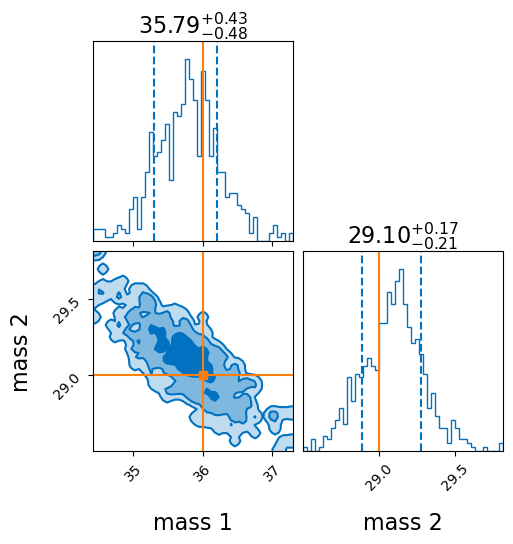

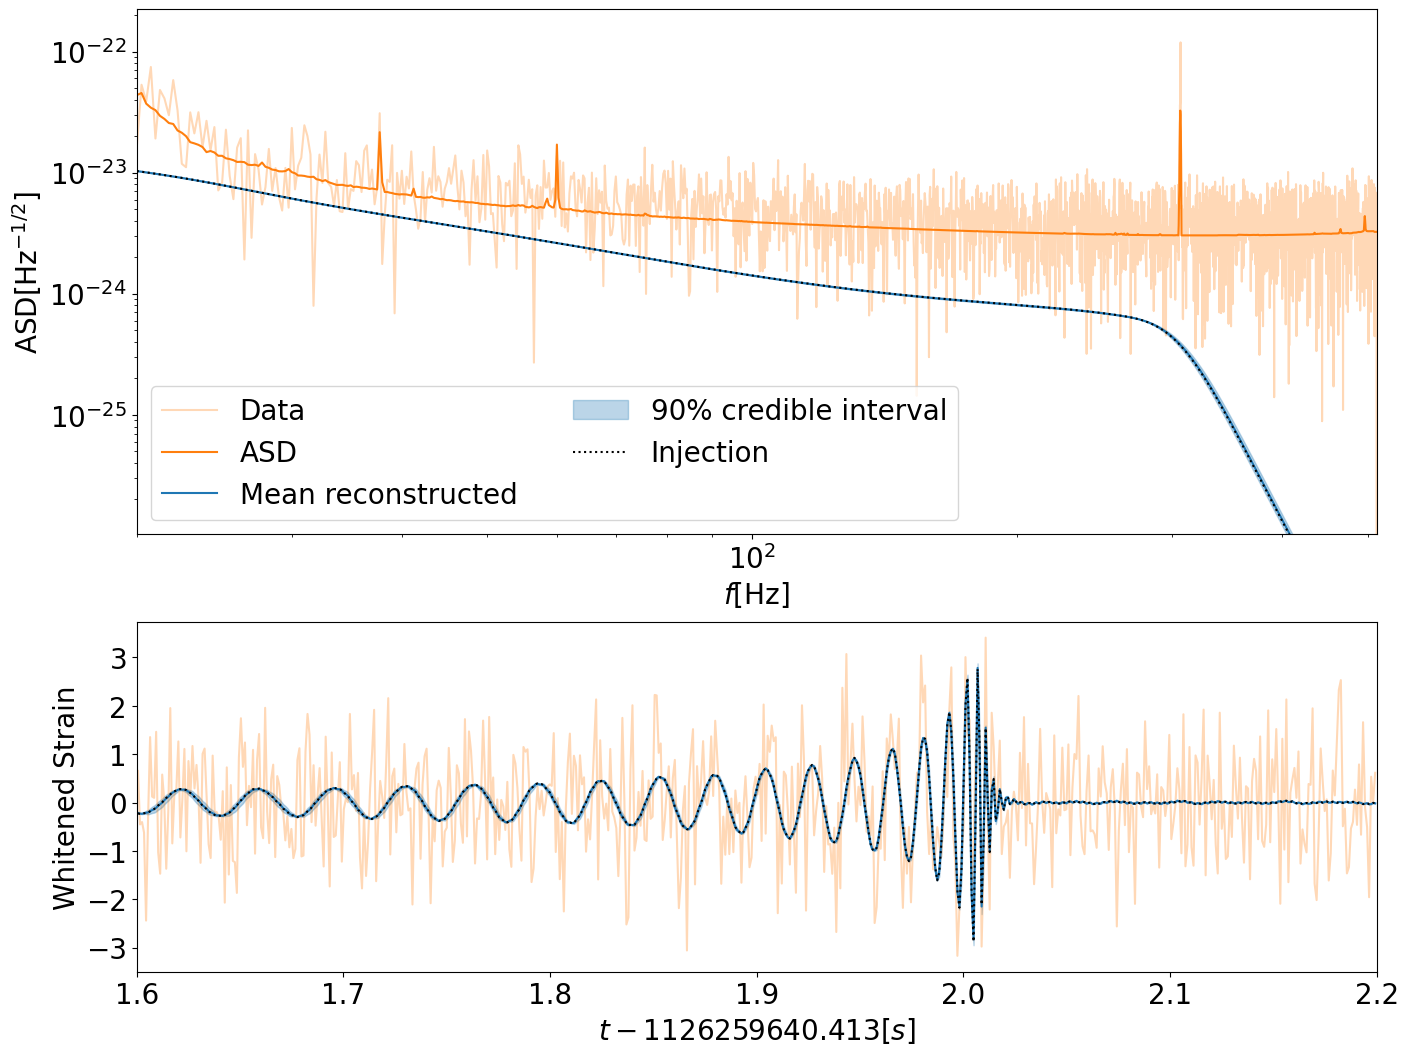

In [6]:
import matplotlib.pyplot as plt
result.plot_corner(parameters=["mass_1", "mass_2"], truths=[inj_m1, inj_m2], save=False)
for interferometer in ifos:
    fig = result.plot_interferometer_waveform_posterior(
        interferometer=interferometer, save=False
    )
    plt.show()

## ML surrogate

In [7]:
import numpy as np
import pandas as pd
import bilby
import multiprocessing
from tqdm import tqdm
import copy

In [8]:
num_samples = 5000

def generate_parameter(m1,m2):
    injection_parameters = dict(
        mass_1=m1,
        mass_2=m2,
        a_1=0.4,
        a_2=0.3,
        tilt_1=0.5,
        tilt_2=1.0,
        phi_12=1.7,
        phi_jl=0.3,
        luminosity_distance=2000.0,
        theta_jn=0.4,
        psi=2.659,
        phase=1.3,
        geocent_time=1126259642.413,
        ra=1.375,
        dec=-1.2108,
    )
    return injection_parameters

mass_1_samples = np.random.normal(36, 0.1, num_samples)
mass_2_samples = np.random.normal(29, 0.1, num_samples)
params = zip(mass_1_samples, mass_2_samples)

# 初始化列表来存储结果
injection_parameters_list = []
waveforms = []



In [9]:
# Fixed arguments passed into the source model
waveform_arguments = dict(
    waveform_approximant="IMRPhenomPv2",
    reference_frequency=20.0,
    minimum_frequency=minimum_frequency,
)

# Create the waveform_generator using a LAL BinaryBlackHole source function
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments,
)

23:45 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [10]:

for m1, m2 in tqdm(zip(mass_1_samples, mass_2_samples), total=num_samples, desc='Generating waveforms'):
    params = generate_parameter(m1, m2)
    injection_parameters_list.append(params)
    
    # 生成纯信号波形
    waveform = waveform_generator.frequency_domain_strain(parameters=params)
    waveforms.append(waveform)

np.save('injection_parameters_list.npy', injection_parameters_list)
np.save('pure_waveforms.npy', waveforms)  # 存储纯信号波形数据

Generating waveforms: 100%|████████████████| 5000/5000 [00:32<00:00, 151.75it/s]


In [13]:
# 假设 waveforms 是你已经生成和保存的波形数据
waveforms = np.load('pure_waveforms.npy', allow_pickle=True)

# 选择可视化的波形数量
num_waveforms_to_plot = 5  # 这里选择显示5个波形

# 计算频率数组
duration = 4.0
sampling_frequency = 1024.0
frequency_array = np.fft.rfftfreq(int(duration * sampling_frequency), d=1/sampling_frequency)

plt.figure(figsize=(10, 8))
for i in range(min(num_waveforms_to_plot, len(waveforms))):
    plt.plot(frequency_array, np.abs(waveforms[i]), label=f'Waveform {i+1}')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain amplitude')
plt.title('Sample Gravitational Waveforms')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.xlim(min(frequency_array), max(frequency_array))
plt.show()

TypeError: bad operand type for abs(): 'dict'

<Figure size 1000x800 with 0 Axes>

In [16]:
waveforms

array([{'plus': array([0.00000000e+00-0.00000000e+00j, 0.00000000e+00-0.00000000e+00j,
              0.00000000e+00-0.00000000e+00j, ...,
              2.29497874e-28+6.45669739e-28j, 2.25755872e-28+6.41998946e-28j,
              0.00000000e+00-0.00000000e+00j]), 'cross': array([0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j, ...,
              6.42963621e-28-2.31573003e-28j, 6.39318465e-28-2.27825540e-28j,
              0.00000000e+00+0.00000000e+00j])}                                                                                ,
       {'plus': array([0.00000000e+00-0.00000000e+00j, 0.00000000e+00-0.00000000e+00j,
              0.00000000e+00-0.00000000e+00j, ...,
              2.59364884e-28+6.39768573e-28j, 2.55438167e-28+6.36239235e-28j,
              0.00000000e+00-0.00000000e+00j]), 'cross': array([0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j, ...,
   